# 1. Introduction

A brief description of your approach to the problem and the results that you 
have obtained on the training data.

\*Insert Introduction here\*

# 2. Data Import

This section is how you import the data into the notebook. It should be written in such 
a way that I can modify it to run on my own machine by simply changing the location 
of the training data and any additional data sources that you have used.

In [27]:
# I intend to use Data Frames to hold our data for now. When putting it in the model,
# I will probably have to change it to another format later but that is a problem for future me, not current me
# (Im joking; please dont deduct points, Mr/Ms Marker)
# Seriously though, Data Frames have very good performance and are malleable for data investigation,
# hence my decision to use them.

import pandas as pd
from pandas import DataFrame as df
import csv

def dataframe_from_diabetic_data_csv(csv_filepath):
    return pd.read_csv(csv_filepath)

TRAINING_DATA_FILEPATH = "BENG0095 (202425) Group Coursework Brief-20251122/Dataset/diabetic_data_training.csv"
TEST_DATA_FILEPATH = "BENG0095 (202425) Group Coursework Brief-20251122/Dataset/diabetic_data_test.csv"

training_data = dataframe_from_diabetic_data_csv(TRAINING_DATA_FILEPATH)
test_data = dataframe_from_diabetic_data_csv(TEST_DATA_FILEPATH)

print(training_data)



       encounter_id  patient_nbr             race  gender      age weight  \
0            149190     55629189        Caucasian  Female  [10-20)      ?   
1             64410     86047875  AfricanAmerican  Female  [20-30)      ?   
2            500364     82442376        Caucasian    Male  [30-40)      ?   
3             16680     42519267        Caucasian    Male  [40-50)      ?   
4             35754     82637451        Caucasian    Male  [50-60)      ?   
...             ...          ...              ...     ...      ...    ...   
91584     443847548    100162476  AfricanAmerican    Male  [70-80)      ?   
91585     443847782     74694222  AfricanAmerican  Female  [80-90)      ?   
91586     443854148     41088789        Caucasian    Male  [70-80)      ?   
91587     443857166     31693671        Caucasian  Female  [80-90)      ?   
91588     443867222    175429310        Caucasian    Male  [70-80)      ?   

       admission_type_id  discharge_disposition_id  admission_source_id  \


# 3. Data Transformation and Exploration
Code for the equivalent section in your report, together with in-line documentation of 
that code.

In [28]:
# I'm going to create some helper functions that might become useful in future.
# Using a few dictionaries I'll allow for mapping from discharge IDs, admission type IDs,
# and admission source IDs, to their true meaning


id_mapping_file_path = "BENG0095 (202425) Group Coursework Brief-20251122/Dataset/IDS_mapping.csv"
admission_type_ids = {}
discharge_ids = {}
admission_source_ids = {}

with open(id_mapping_file_path, newline = '') as csvfile:
    csvreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in csvreader:
        if row[0] == 'admission_type_id':
            current_dictionary = 'AT'
        elif row[0] == 'discharge_disposition_id':
            current_dictionary = 'DD'
        elif row[0] == 'admission_source_id':
            current_dictionary = 'AS'
        elif row[0] == '':
            continue
        elif current_dictionary == 'AT':
            admission_type_ids[int(row[0])] = row[1]
        elif current_dictionary == 'DD':
            discharge_ids[int(row[0])] = row[1]
        else:
            admission_source_ids[int(row[0])] = row[1]
        
def get_admission_type(admission_type_id):
    try:
        return admission_type_ids[admission_type_id]
    except:
        return 'INVALID ADMISSION TYPE ID'

def get_discharge_type(discharge_id):
    try:
        return discharge_ids[discharge_id]
    except:
        return 'INVALID DISCHARGE ID'

def get_admission_source_ids(admission_source_id):
    try:
        return admission_source_ids[admission_source_id]
    except:
        return 'INVALID ADMISSION SOURCE ID'

#print(admission_type_ids)
#print(discharge_ids)
#print(admission_source_ids)

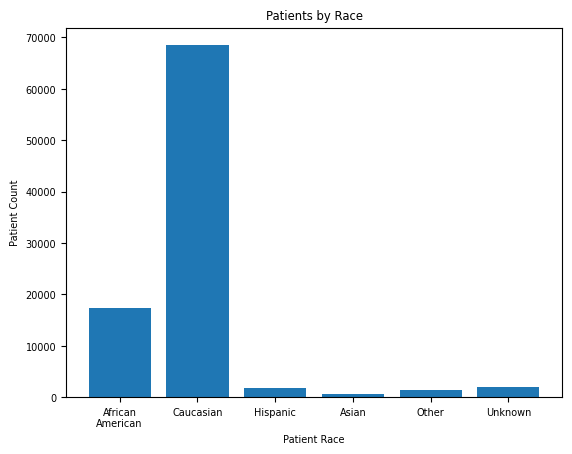

In [29]:
# I want to create some data visualisations that can provide some insights.
# I intend to use these insights to inform how I set up the model's architecture

import matplotlib
from matplotlib import pyplot as plt

# Grouping Patients by Race
african_americans = training_data[training_data['race']=='AfricanAmerican']
african_american_patients = len(african_americans)

caucasians = training_data[training_data['race'] == 'Caucasian']
caucasian_patients = len(caucasians)

hispanics = training_data[training_data['race'] == 'Hispanic']
hispanic_patients = len(hispanics)

asians = training_data[training_data['race'] == 'Asian']
asian_patients = len(asians)

others = training_data[training_data['race'] == 'Other']
other_race_patients = len(others)

unknowns = training_data[training_data['race'] == '?']
unknown_race_patients = len(unknowns)

races = ['African\nAmerican', 'Caucasian', 'Hispanic', 'Asian', 'Other', 'Unknown']
patient_counts = [african_american_patients, caucasian_patients, hispanic_patients, asian_patients, other_race_patients, unknown_race_patients]

plt.bar(races, patient_counts)
plt.title("Patients by Race")
plt.xlabel("Patient Race")
plt.ylabel("Patient Count")
plt.show()

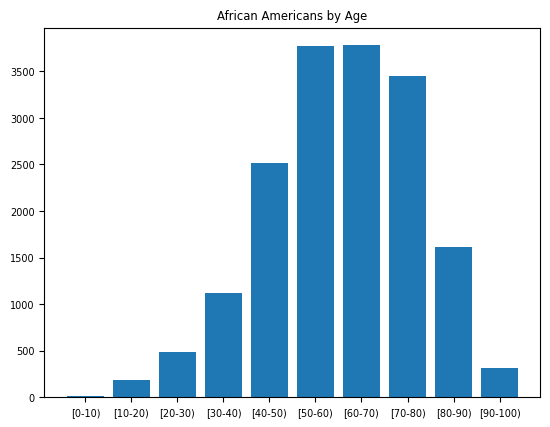

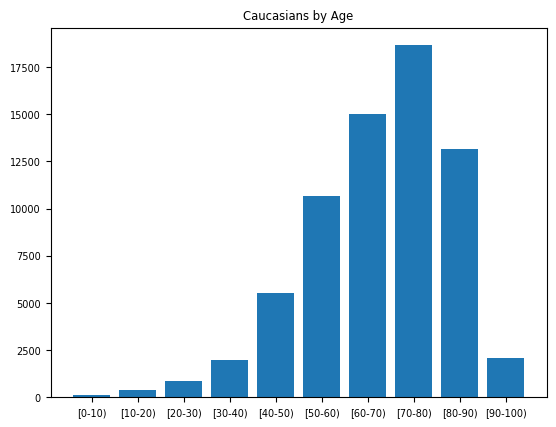

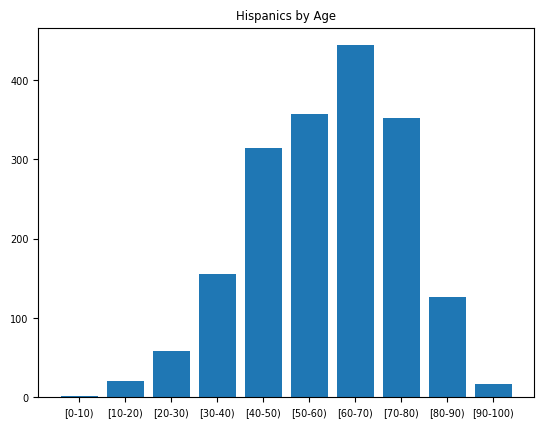

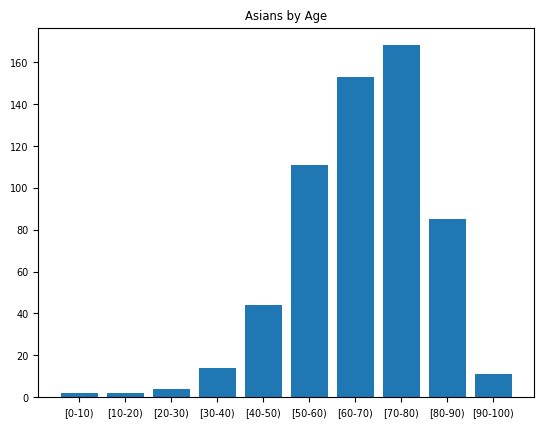

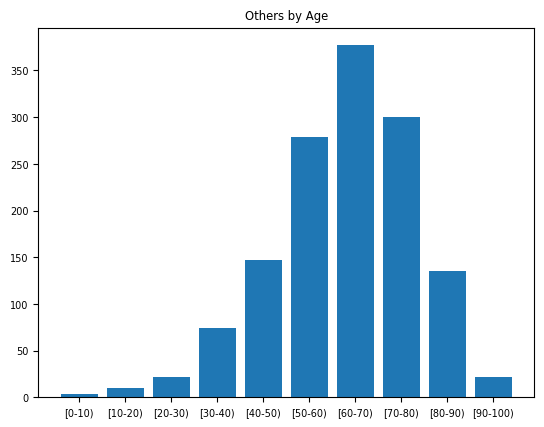

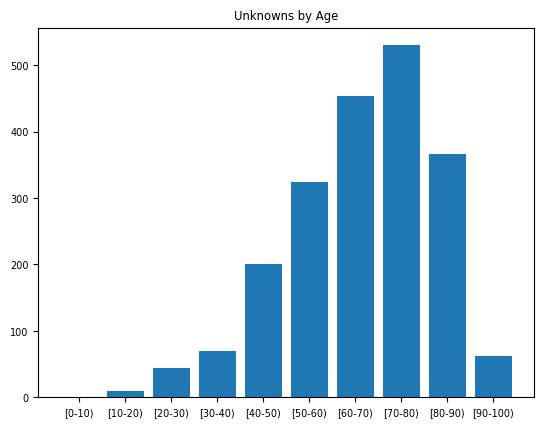

In [30]:
# Grouping patients by age within race
# '[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)' '[70-80)' '[80-90)' '[90-100)' '[0-10)'
age_brackets = ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)']
african_americans_by_age = [len(african_americans[african_americans['age'] == bracket]) for bracket in age_brackets]
caucasians_by_age = [len(caucasians[caucasians['age'] == bracket]) for bracket in age_brackets]
hispanics_by_age = [len(hispanics[hispanics['age'] == bracket]) for bracket in age_brackets]
asians_by_age = [len(asians[asians['age'] == bracket]) for bracket in age_brackets]
others_by_age = [len(others[others['age'] == bracket]) for bracket in age_brackets]
unknowns_by_age = [len(unknowns[unknowns['age'] == bracket]) for bracket in age_brackets]

plt.rcParams.update({'font.size': 7})

plt.bar(age_brackets, african_americans_by_age)
plt.title('African Americans by Age')
plt.show()

plt.bar(age_brackets, caucasians_by_age)
plt.title('Caucasians by Age')
plt.show()

plt.bar(age_brackets, hispanics_by_age)
plt.title('Hispanics by Age')
plt.show()

plt.bar(age_brackets, asians_by_age)
plt.title('Asians by Age')
plt.show()

plt.bar(age_brackets, others_by_age)
plt.title('Others by Age')
plt.show()

plt.bar(age_brackets, unknowns_by_age)
plt.title('Unknowns by Age')
plt.show()

plt.rcParams.clear()
# african_american_axes = plt.subplot(3, 3, 1)
# african_american_axes.bar(age_brackets, african_americans_by_age)
# african_american_axes.set_title('African Americans by Age', fontsize = 7)


# caucasian_axes = plt.subplot(3, 3, 2)
# caucasian_axes.bar(age_brackets, caucasians_by_age)
# caucasian_axes.set_title('Caucasians by Age', fontsize = 7)


# hispanic_axes = plt.subplot(3, 3, 3)
# hispanic_axes.bar(age_brackets, hispanics_by_age)
# hispanic_axes.set_title('Hispanics by Age', fontsize = 7)


# asian_axes = plt.subplot(3, 3, 4)
# asian_axes.bar(age_brackets, asians_by_age)
# asian_axes.set_title('Asians by Age', fontsize = 7)


# other_axes = plt.subplot(3, 3, 5)
# other_axes.bar(age_brackets, others_by_age)
# other_axes.set_title('Others by Age', fontsize = 7)


# unknown_axes = plt.subplot(3, 3, 6)
# unknown_axes.bar(age_brackets, unknowns_by_age)
# unknown_axes.set_title('Unknowns by Age', fontsize = 7)


# plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.2)

# plt.show()



1:  Physician Referral
2: Clinic Referral
3: HMO Referral
4: Transfer from a hospital
5:  Transfer from a Skilled Nursing Facility (SNF)
6:  Transfer from another health care facility
7:  Emergency Room
8:  Court/Law Enforcement
9:  Not Available
10:  Transfer from critial access hospital
11: Normal Delivery
13:  Sick Baby
14:  Extramural Birth
17: NULL
20:  Not Mapped
22:  Transfer from hospital inpt/same fac reslt in a sep claim
25:  Transfer from Ambulatory Surgery Center


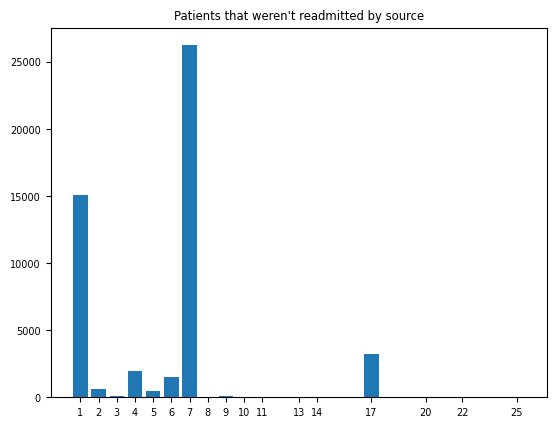

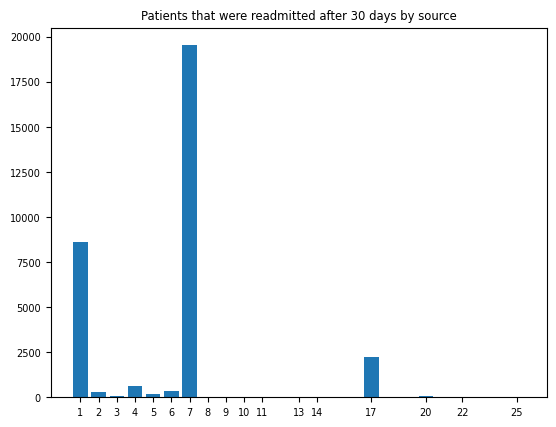

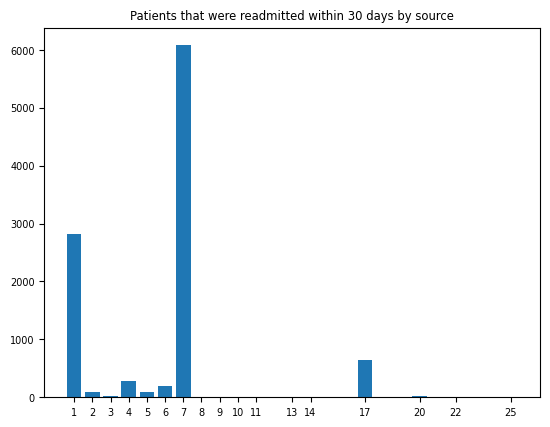

In [31]:
# Let's visualise the patient's outcome (readmittance) based on their admittance

patients_not_readmitted = training_data[training_data['readmitted'] == 'NO']
patients_readmitted_after_30_days = training_data[training_data['readmitted'] == '>30']
patients_readmitted_within_30_days = training_data[training_data['readmitted'] == '<30']

admission_sources = list(training_data['admission_source_id'].unique())
admission_sources.sort()

# Now that we have the patients separated by their outcome, lets visualise what made them go to the hospital
not_readmitted_patients_by_source = [len(patients_not_readmitted[patients_not_readmitted['admission_source_id'] == aso]) for aso in admission_sources]
readmitted_patients_after_30_days_by_source = [len(patients_readmitted_after_30_days[patients_readmitted_after_30_days['admission_source_id'] == aso]) for aso in admission_sources]
readmitted_patients_within_30_days_by_source = [len(patients_readmitted_within_30_days[patients_readmitted_within_30_days['admission_source_id'] == aso]) for aso in admission_sources]

for aso in admission_sources:
    print(f"{aso}: {get_admission_source_ids(aso)}")

plt.bar(admission_sources, not_readmitted_patients_by_source)
plt.title("Patients that weren't readmitted by source")
plt.xticks(admission_sources)
plt.show()
plt.bar(admission_sources, readmitted_patients_after_30_days_by_source)
plt.title("Patients that were readmitted after 30 days by source")
plt.xticks(admission_sources)
plt.show()
plt.bar(admission_sources, readmitted_patients_within_30_days_by_source)
plt.title("Patients that were readmitted within 30 days by source")
plt.xticks(admission_sources)
plt.show()




# print(len(patients_not_readmitted), len(patients_readmitted_after_30), len(patients_readmitted_within_30))

In [32]:
# cleaning and visualising for previous hospital encounters

df = pd.read_csv(TRAINING_DATA_FILEPATH)

cols = ["number_inpatient", "number_outpatient", "number_emergency"]

df[cols] = df[cols].apply(pd.to_numeric, errors="coerce")

# Replace NaN with 0 (patients often have no prior visits)
df[cols] = df[cols].fillna(0)

# Clip extreme outliers (very rare >10 visits)
df[cols] = df[cols].clip(0, 10)

df["total_visits"] = df["number_inpatient"] + df["number_outpatient"] + df["number_emergency"]

df[cols + ["total_visits"]]


,number_inpatient,number_outpatient,number_emergency,total_visits
0,0,0,0,0
1,1,2,0,3
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
...,...,...,...,...
91584,0,0,0,0
91585,1,0,0,1
91586,0,1,0,1
91587,1,0,0,1


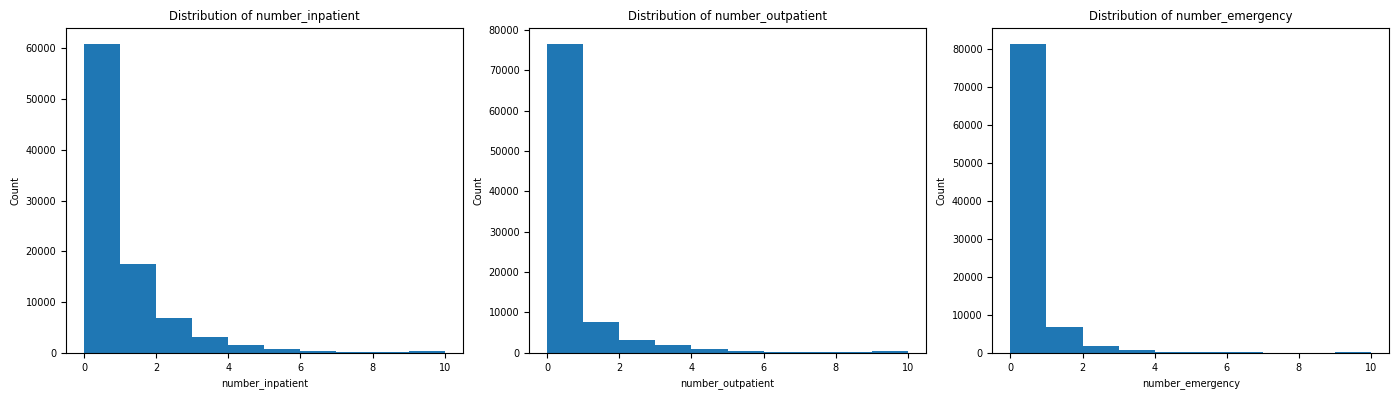

In [33]:
plt.figure(figsize=(14,4))

for i, col in enumerate(cols):
    plt.subplot(1, 3, i+1)
    plt.hist(df[col], bins=10)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")

plt.tight_layout()
plt.show()

/var/folders/8r/nf1xtqhn70bcqvr9dyfv37jc0000gn/T/ipykernel_1222/772264036.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(df[cols], labels=cols)


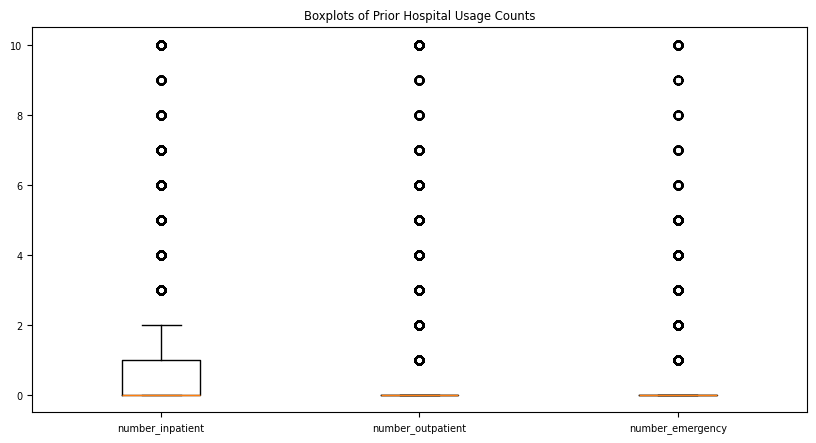

In [34]:
plt.figure(figsize=(10,5))
plt.boxplot(df[cols], labels=cols)
plt.title("Boxplots of Prior Hospital Usage Counts")
plt.show()


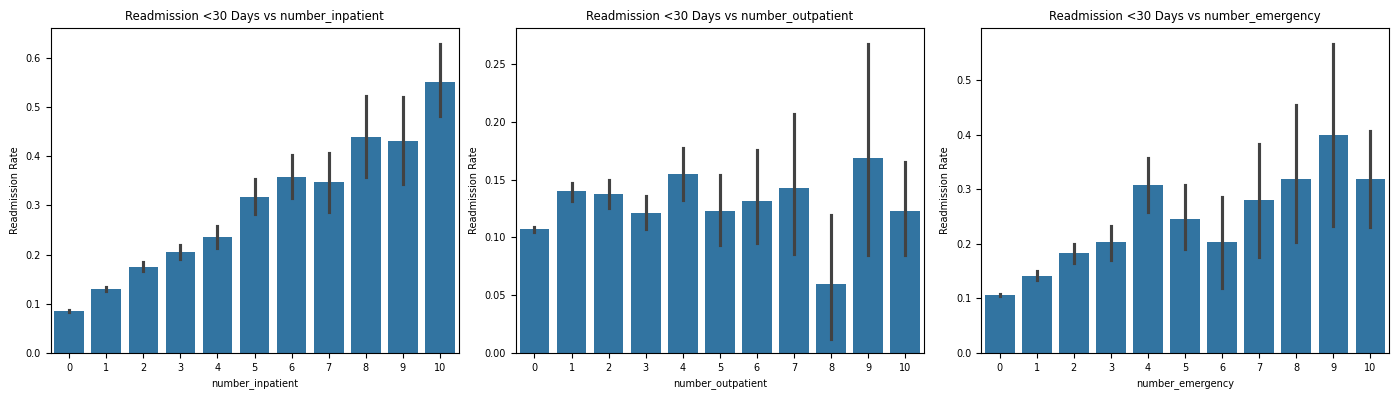

In [35]:
import seaborn as sns

plt.figure(figsize=(14,4))

for i, col in enumerate(cols):
    plt.subplot(1, 3, i+1)
    sns.barplot(x=df[col], y=(df["readmitted"]=="<30").astype(int))
    plt.title(f"Readmission <30 Days vs {col}")
    plt.ylabel("Readmission Rate")

plt.tight_layout()
plt.show()


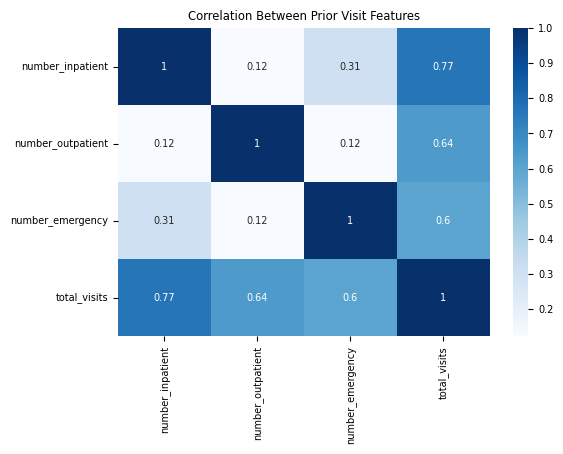

In [36]:
plt.figure(figsize=(6,4))
sns.heatmap(df[cols + ["total_visits"]].corr(), annot=True, cmap="Blues")
plt.title("Correlation Between Prior Visit Features")
plt.show()

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset (modify if needed)
df = pd.read_csv(TRAINING_DATA_FILEPATH)

# Columns to clean
encounter_cols = [
    "time_in_hospital",
    "admission_type_id",
    "discharge_disposition_id",
    "admission_source_id"
]

# Convert to numeric
df[encounter_cols] = df[encounter_cols].apply(pd.to_numeric, errors="coerce")

# Replace any NaN with a special category (rare)
df[["admission_type_id", "discharge_disposition_id", "admission_source_id"]] = \
    df[["admission_type_id", "discharge_disposition_id", "admission_source_id"]].fillna(-1)

# Ensure time_in_hospital has no NaN
df["time_in_hospital"] = df["time_in_hospital"].fillna(df["time_in_hospital"].median())

df[encounter_cols].head()


,time_in_hospital,admission_type_id,discharge_disposition_id,admission_source_id
0,3,1,1,7
1,2,1,1,7
2,2,1,1,7
3,1,1,1,7
4,3,2,1,2


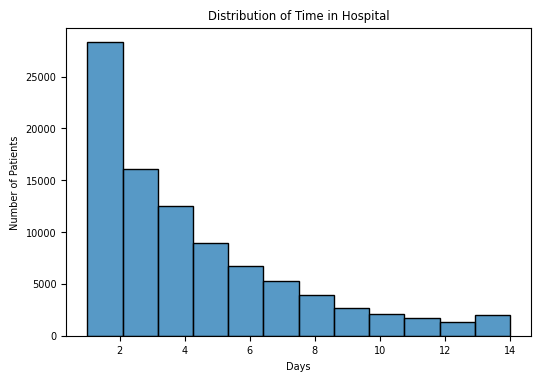

In [38]:
plt.figure(figsize=(6,4))
sns.histplot(df["time_in_hospital"], bins=12, kde=False)
plt.title("Distribution of Time in Hospital")
plt.xlabel("Days")
plt.ylabel("Number of Patients")
plt.show()


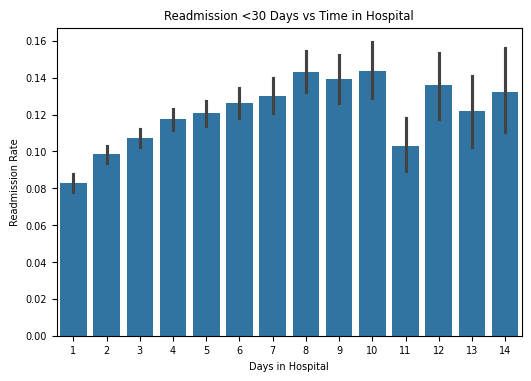

In [39]:
plt.figure(figsize=(6,4))
sns.barplot(x=df["time_in_hospital"], 
            y=(df["readmitted"]=="<30").astype(int))
plt.title("Readmission <30 Days vs Time in Hospital")
plt.xlabel("Days in Hospital")
plt.ylabel("Readmission Rate")
plt.show()


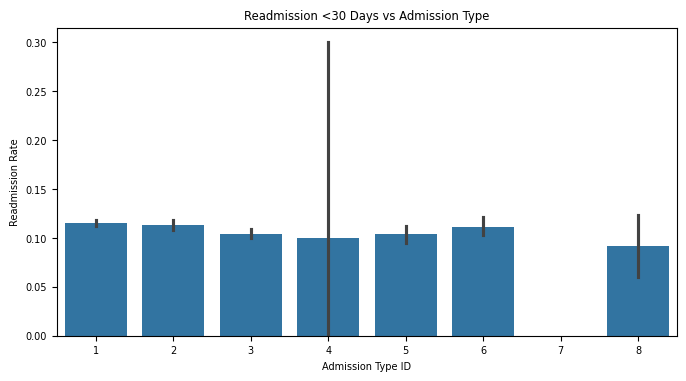

In [40]:
plt.figure(figsize=(8,4))
sns.barplot(x=df["admission_type_id"], 
            y=(df["readmitted"]=="<30").astype(int))
plt.title("Readmission <30 Days vs Admission Type")
plt.xlabel("Admission Type ID")
plt.ylabel("Readmission Rate")
plt.show()


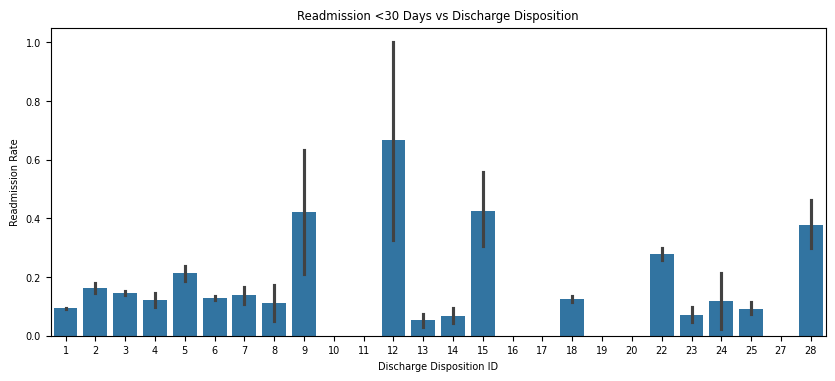

In [41]:
plt.figure(figsize=(10,4))
sns.barplot(x=df["discharge_disposition_id"], 
            y=(df["readmitted"]=="<30").astype(int))
plt.title("Readmission <30 Days vs Discharge Disposition")
plt.xlabel("Discharge Disposition ID")
plt.ylabel("Readmission Rate")
plt.show()


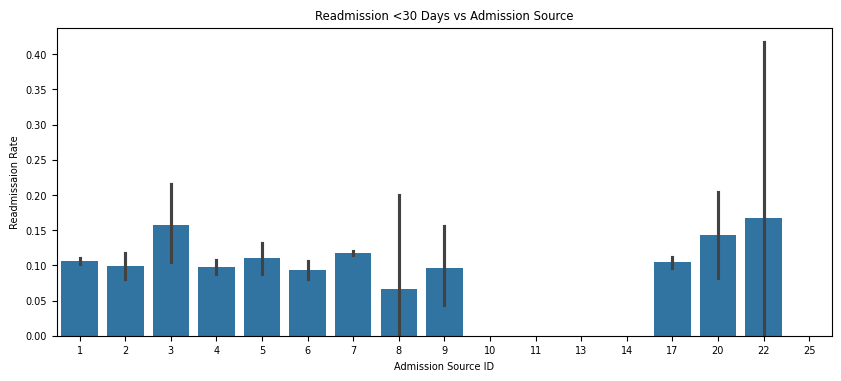

In [42]:
plt.figure(figsize=(10,4))
sns.barplot(x=df["admission_source_id"], 
            y=(df["readmitted"]=="<30").astype(int))
plt.title("Readmission <30 Days vs Admission Source")
plt.xlabel("Admission Source ID")
plt.ylabel("Readmissaion Rate")
plt.show()


In [43]:
## Simple neural network

## Using: 'race','gender','age', 'admission_type_id','discharge_disposition_id'
##        'number_inpatient','number_emergency','time_in_hospital'

# Predicting: readmitted

import pandas as pd

df = pd.read_csv(TRAINING_DATA_FILEPATH)

cols = [
    'race','gender','age',
    'admission_type_id','discharge_disposition_id',
    'number_inpatient','number_emergency','time_in_hospital',
    'readmitted'
]
data = df[cols].copy()

print(data["race"].unique())
print(data["gender"].unique())
print(data["age"].unique())

# Race: drop unknown
data = data[data['race'] != '?']

# Gender: drop invalid
data = data[data['gender'] != 'Unknown/Invalid']

def get_age_mid(row):
    row = row[1:-1]
    start, end = list(map(int, row.split("-")))
    return (start + end) / 2

data["age_midpoint"] = data["age"].apply(get_age_mid)
data["age_midpoint"].dropna()

data['readmit_binary'] = (data['readmitted'] != 'NO').astype(int)

['Caucasian' 'AfricanAmerican' '?' 'Other' 'Hispanic' 'Asian']
['Female' 'Male' 'Unknown/Invalid']
['[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)' '[70-80)'
 '[80-90)' '[90-100)' '[0-10)']


In [44]:

from sklearn.model_selection import train_test_split
X = data[[
    'race','gender','age_midpoint',
    'admission_type_id','discharge_disposition_id',
    'number_inpatient','number_emergency','time_in_hospital'
]]

y = data['readmit_binary']

# One-hot encode race, gender
X = pd.get_dummies(X, columns=['race','gender'], drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [45]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, classification_report

print(X_test.shape)


(17906, 11)


In [46]:
numeric = [
    'age_midpoint','admission_type_id','discharge_disposition_id',
    'number_inpatient','number_emergency','time_in_hospital'
]
scaler = StandardScaler()
X_train[numeric] = scaler.fit_transform(X_train[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])


model = Sequential([
    Dense(32, activation="relu", input_shape=(X_test.shape[1],)),
    Dense(16, activation="relu"),
    Dense(8, activation="relu"),
    Dense(4, activation="relu"),
    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    verbose=1
)

Epoch 1/20


/Users/tneethesh/Desktop/BENG Coursework/BENG0095CW/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1791/1791 ━━━━━━━━━━━━━━━━━━━━ 1s 435us/step - accuracy: 0.6112 - loss: 0.6576 - val_accuracy: 0.6193 - val_loss: 0.6525
Epoch 2/20
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 1s 388us/step - accuracy: 0.6192 - loss: 0.6504 - val_accuracy: 0.6250 - val_loss: 0.6475
Epoch 3/20
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 1s 390us/step - accuracy: 0.6242 - loss: 0.6458 - val_accuracy: 0.6272 - val_loss: 0.6461
Epoch 4/20
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 1s 377us/step - accuracy: 0.6234 - loss: 0.6428 - val_accuracy: 0.6259 - val_loss: 0.6427
Epoch 5/20
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 1s 373us/step - accuracy: 0.6249 - loss: 0.6415 - val_accuracy: 0.6274 - val_loss: 0.6425
Epoch 6/20
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 1s 374us/step - accuracy: 0.6247 - loss: 0.6408 - val_accuracy: 0.6281 - val_loss: 0.6416
Epoch 7/20
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 1s 378us/step - accuracy: 0.6260 - loss: 0.6398 - val_accuracy: 0.6262 - val_loss: 0.6416
Epoch 8/20
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 1s 378us/step - accuracy: 0.6263 - loss: 0.63

In [47]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:")
print(classification_report(y_test, y_pred))

560/560 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
Accuracy: 0.6274991622919692

Classification report:
              precision    recall  f1-score   support

           0       0.64      0.69      0.67      9592
           1       0.61      0.55      0.58      8314

    accuracy                           0.63     17906
   macro avg       0.62      0.62      0.62     17906
weighted avg       0.63      0.63      0.63     17906



# 4. Methodology Overview
Code for the equivalent section in your report, together with in-line documentation of 
that code.

# 5. Model Training & Validation
Code for the equivalent section in your report, together with in-line documentation of 
that code.

## Two-stage classifier (readmitted vs NO, then <30 vs >30)
We first train a binary classifier to decide whether a patient will be readmitted at all.
Then, only for predicted readmissions, we train a second classifier to predict <30 vs >30 days.


In [48]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Load and lightly clean data
raw = pd.read_csv(TRAINING_DATA_FILEPATH)
raw = raw.replace("?", np.nan)
raw = raw.replace("Unknown/Invalid", np.nan)

categorical_features = [
    "race",
    "gender",
    "age",
    "admission_type_id",
    "discharge_disposition_id",
    "admission_source_id",
    "max_glu_serum",
    "A1Cresult",
    "payer_code",
    "medical_specialty",
    "change",
    "diabetesMed",
]

numeric_features = [
    "time_in_hospital",
    "num_lab_procedures",
    "num_procedures",
    "num_medications",
    "number_outpatient",
    "number_emergency",
    "number_inpatient",
    "number_diagnoses",
]

# Ensure numeric columns are numeric dtype
for col in numeric_features:
    raw[col] = pd.to_numeric(raw[col], errors="coerce")


feature_cols = categorical_features + numeric_features
X = raw[feature_cols]
y = raw["readmitted"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


def make_preprocessor():
    numeric_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ]
    )
    categorical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore")),
        ]
    )
    return ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features),
        ],
        remainder="drop",
    )


In [49]:
# Stage 1: Readmitted vs NO
stage1 = Pipeline(
    steps=[
        ("preprocess", make_preprocessor()),
        (
            "clf",
            LogisticRegression(
                max_iter=1000,
                class_weight="balanced",
                solver="liblinear",
            ),
        ),
    ]
)

y1_train = (y_train != "NO").astype(int)
y1_test = (y_test != "NO").astype(int)

stage1.fit(X_train, y1_train)
y1_pred = stage1.predict(X_test)

print("Stage 1: Readmitted vs NO")
print(classification_report(y1_test, y1_pred, target_names=["NO", "Readmitted"], zero_division=0))


Stage 1: Readmitted vs NO
              precision    recall  f1-score   support

          NO       0.66      0.64      0.65      9871
  Readmitted       0.60      0.61      0.60      8447

    accuracy                           0.63     18318
   macro avg       0.63      0.63      0.63     18318
weighted avg       0.63      0.63      0.63     18318



In [50]:
# Stage 2: <30 vs >30 (only among readmitted)
stage2 = Pipeline(
    steps=[
        ("preprocess", make_preprocessor()),
        (
            "clf",
            LogisticRegression(
                max_iter=1000,
                class_weight="balanced",
                solver="liblinear",
            ),
        ),
    ]
)

train_readmit_mask = y_train != "NO"
test_readmit_mask = y_test != "NO"

X_train_r = X_train[train_readmit_mask]
X_test_r = X_test[test_readmit_mask]

y2_train = (y_train[train_readmit_mask] == "<30").astype(int)
y2_test = (y_test[test_readmit_mask] == "<30").astype(int)

stage2.fit(X_train_r, y2_train)
y2_pred = stage2.predict(X_test_r)

print("Stage 2: <30 vs >30")
print(classification_report(y2_test, y2_pred, target_names=[">30", "<30"], zero_division=0))


Stage 2: <30 vs >30
              precision    recall  f1-score   support

         >30       0.81      0.67      0.73      6398
         <30       0.33      0.51      0.40      2049

    accuracy                           0.63      8447
   macro avg       0.57      0.59      0.57      8447
weighted avg       0.69      0.63      0.65      8447



In [51]:
# Combined 3-class prediction on the test split
final_pred = np.array(["NO"] * len(y_test), dtype=object)
readmit_pred_mask = y1_pred == 1

if readmit_pred_mask.any():
    stage2_pred = stage2.predict(X_test[readmit_pred_mask])
    final_pred[readmit_pred_mask] = np.where(stage2_pred == 1, "<30", ">30")

print("Two-stage combined (3-class)")
print(classification_report(
    y_test,
    final_pred,
    labels=["NO", ">30", "<30"],
    target_names=["NO", ">30", "<30"],
    zero_division=0,
))


Two-stage combined (3-class)
              precision    recall  f1-score   support

          NO       0.66      0.64      0.65      9871
         >30       0.46      0.37      0.41      6398
         <30       0.21      0.36      0.27      2049

    accuracy                           0.52     18318
   macro avg       0.44      0.46      0.44     18318
weighted avg       0.54      0.52      0.52     18318



## Two-stage classifier (MLP swap)
This is the same two-stage setup, but each stage uses an MLP instead of logistic regression.
Run the data/preprocessing cell above first.


In [52]:
from sklearn.neural_network import MLPClassifier

# Stage 1: Readmitted vs NO (MLP)
stage1_mlp = Pipeline(
    steps=[
        ("preprocess", make_preprocessor()),
        (
            "clf",
            MLPClassifier(
                hidden_layer_sizes=(64, 32),
                activation="relu",
                solver="adam",
                max_iter=200,
                random_state=42,
            ),
        ),
    ]
)

y1_pred_mlp = stage1_mlp.fit(X_train, y1_train).predict(X_test)

print("Stage 1 (MLP): Readmitted vs NO")
print(classification_report(y1_test, y1_pred_mlp, target_names=["NO", "Readmitted"], zero_division=0))

# Stage 2: <30 vs >30 (MLP, only among readmitted)
stage2_mlp = Pipeline(
    steps=[
        ("preprocess", make_preprocessor()),
        (
            "clf",
            MLPClassifier(
                hidden_layer_sizes=(64, 32),
                activation="relu",
                solver="adam",
                max_iter=200,
                random_state=42,
            ),
        ),
    ]
)

y2_pred_mlp = stage2_mlp.fit(X_train_r, y2_train).predict(X_test_r)

print("Stage 2 (MLP): <30 vs >30")
print(classification_report(y2_test, y2_pred_mlp, target_names=[">30", "<30"], zero_division=0))

# Combined 3-class prediction on the test split (MLP)
final_pred_mlp = np.array(["NO"] * len(y_test), dtype=object)
readmit_pred_mask_mlp = y1_pred_mlp == 1

if readmit_pred_mask_mlp.any():
    stage2_pred_mlp = stage2_mlp.predict(X_test[readmit_pred_mask_mlp])
    final_pred_mlp[readmit_pred_mask_mlp] = np.where(stage2_pred_mlp == 1, "<30", ">30")

print("Two-stage combined (MLP, 3-class)")
print(classification_report(
    y_test,
    final_pred_mlp,
    labels=["NO", ">30", "<30"],
    target_names=["NO", ">30", "<30"],
    zero_division=0,
))


/Users/tneethesh/Desktop/BENG Coursework/BENG0095CW/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Stage 1 (MLP): Readmitted vs NO
              precision    recall  f1-score   support

          NO       0.64      0.63      0.63      9871
  Readmitted       0.58      0.59      0.58      8447

    accuracy                           0.61     18318
   macro avg       0.61      0.61      0.61     18318
weighted avg       0.61      0.61      0.61     18318

Stage 2 (MLP): <30 vs >30
              precision    recall  f1-score   support

         >30       0.77      0.86      0.82      6398
         <30       0.34      0.22      0.26      2049

    accuracy                           0.71      8447
   macro avg       0.56      0.54      0.54      8447
weighted avg       0.67      0.71      0.68      8447

Two-stage combined (MLP, 3-class)
              precision    recall  f1-score   support

          NO       0.64      0.63      0.63      9871
         >30       0.44      0.50      0.47      6398
         <30       0.20      0.14      0.16      2049

    accuracy                        

/Users/tneethesh/Desktop/BENG Coursework/BENG0095CW/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## Two-stage classifier (Naive Bayes swap)
Same two-stage setup, but each stage uses Multinomial Naive Bayes.
Run the data/preprocessing cell above first.


In [53]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

# Naive Bayes prefers non-negative features, so use MinMaxScaler for numeric columns.
def make_nb_preprocessor():
    numeric_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", MinMaxScaler()),
        ]
    )
    categorical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore")),
        ]
    )
    return ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features),
        ],
        remainder="drop",
    )

# Stage 1: Readmitted vs NO (Naive Bayes)
stage1_nb = Pipeline(
    steps=[
        ("preprocess", make_nb_preprocessor()),
        ("clf", MultinomialNB()),
    ]
)

y1_train_nb = (y_train != "NO").astype(int)
y1_test_nb = (y_test != "NO").astype(int)

y1_pred_nb = stage1_nb.fit(X_train, y1_train_nb).predict(X_test)

print("Stage 1 (NB): Readmitted vs NO")
print(classification_report(y1_test_nb, y1_pred_nb, target_names=["NO", "Readmitted"], zero_division=0))

# Stage 2: <30 vs >30 (Naive Bayes, only among readmitted)
stage2_nb = Pipeline(
    steps=[
        ("preprocess", make_nb_preprocessor()),
        ("clf", MultinomialNB()),
    ]
)

train_readmit_mask_nb = y_train != "NO"
test_readmit_mask_nb = y_test != "NO"

X_train_r_nb = X_train[train_readmit_mask_nb]
X_test_r_nb = X_test[test_readmit_mask_nb]

y2_train_nb = (y_train[train_readmit_mask_nb] == "<30").astype(int)
y2_test_nb = (y_test[test_readmit_mask_nb] == "<30").astype(int)

y2_pred_nb = stage2_nb.fit(X_train_r_nb, y2_train_nb).predict(X_test_r_nb)

print("Stage 2 (NB): <30 vs >30")
print(classification_report(y2_test_nb, y2_pred_nb, target_names=[">30", "<30"], zero_division=0))

# Combined 3-class prediction on the test split (Naive Bayes)
final_pred_nb = np.array(["NO"] * len(y_test), dtype=object)
readmit_pred_mask_nb = y1_pred_nb == 1

if readmit_pred_mask_nb.any():
    stage2_pred_nb = stage2_nb.predict(X_test[readmit_pred_mask_nb])
    final_pred_nb[readmit_pred_mask_nb] = np.where(stage2_pred_nb == 1, "<30", ">30")

print("Two-stage combined (NB, 3-class)")
print(classification_report(
    y_test,
    final_pred_nb,
    labels=["NO", ">30", "<30"],
    target_names=["NO", ">30", "<30"],
    zero_division=0,
))


Stage 1 (NB): Readmitted vs NO
              precision    recall  f1-score   support

          NO       0.62      0.62      0.62      9871
  Readmitted       0.55      0.55      0.55      8447

    accuracy                           0.59     18318
   macro avg       0.58      0.58      0.58     18318
weighted avg       0.59      0.59      0.59     18318

Stage 2 (NB): <30 vs >30
              precision    recall  f1-score   support

         >30       0.77      0.98      0.86      6398
         <30       0.53      0.06      0.10      2049

    accuracy                           0.76      8447
   macro avg       0.65      0.52      0.48      8447
weighted avg       0.71      0.76      0.68      8447

Two-stage combined (NB, 3-class)
              precision    recall  f1-score   support

          NO       0.62      0.62      0.62      9871
         >30       0.42      0.54      0.47      6398
         <30       0.28      0.03      0.05      2049

    accuracy                           

# 6. Results
Code for the equivalent section in your report, together with in-line documentation of 
that code.

# 7. Final Predictions on Test Set
Code for the equivalent section in your report, together with in-line documentation of 
that code.